#### **Showcase 3: Cell conductances to global cerebral dynamics; a model summarizing scales of spontaneous and evoked activity in asynchronous and synchronous brain states.**

#### **Part 2:** Evoked activity

###### *This code has been prepared for EBRAINS by Lionel Kusch, Bahar Hazal Yalçınkaya, Thierry Nieus, Trang-Anh Nghiem, and Jennifer Goldman*
###### *Supervised by Viktor Jirsa, Marcello Massimini, and Alain Destexhe*

##### To generate and analyze simulated brain activity using the TVB-AdEX, first Import TVB from EBRAINS:

In [9]:
%%capture --no-display
!pip install --upgrade tvb-library
!pip install --upgrade tvb-data

In [10]:
!pip install bitarray

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [11]:
## Define location to save files
folder_root = './result/'

import sys 
import os


## Import parameters files and tools
from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
import tvb_model_reference.src.tools_simulation as tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from IPython.display import clear_output
import numpy as np
import copy
from scipy import signal
import analysis_vestigial.Lempel_Ziv as lz
import seaborn
import time
import pci_v2

##### Next, chose the length of your simulation (in milliseconds).
##### Keep in mind that we will discard 2000 ms for the transient of the model and will analyze 300 ms before and after the stimulus to calculate the perturbational complexity index (PCI).

In [12]:
run_sim = 4000.0 # Length of simulation in milliseconds

##### Set up the parameters of the model

In [13]:
parameters = Parameter()
nregions = 68 #Number of regions in the parcellation. Here, 68 from the Berlin connectomes determined from HCP data

# Loop over values of b_e
bvals = [0 , 20, 40, 60] #Values of spike-frequency adaptation giving synchronous and asynchronous states

# Loop over values of stimulus strength
stimvals = [1e-5 ,1e-4, 1e-3]

# The model takes time to stabilize. This is the time to discard after initialization
cut_transient = 2000.0 # In ms 
t_analysis  = 300. # ms, for PCI

# Loop over seeds to obtain multi5ple realizations of the model
Nseeds = 40 #Number of seeds has been reduced from 50 in the manuscript to 5 in the demonstrator for the reviewers' convenience 


# Onset time of the stimulus
stimtime_allseeds = np.random.rand(Nseeds)*(run_sim - cut_transient - 2*t_analysis) + t_analysis + cut_transient # shuffle in ms the start time of stimulus 
#There must be 300ms available before and after the stimulus for the PCI analysis.

##### These are the regions in the Berlin parcellation used here.

In [14]:
simulator = tools.init(parameters.parameter_simulation,
                              parameters.parameter_model,
                              parameters.parameter_connection_between_region,
                              parameters.parameter_coupling,
                              parameters.parameter_integrator,
                              parameters.parameter_monitor)
                       
simulator.connectivity.region_labels

array(['bankssts_L', 'bankssts_R', 'caudalanteriorcingulate_L',
       'caudalanteriorcingulate_R', 'caudalmiddlefrontal_L',
       'caudalmiddlefrontal_R', 'cuneus_L', 'cuneus_R', 'entorhinal_L',
       'entorhinal_R', 'frontalpole_L', 'frontalpole_R', 'fusiform_L',
       'fusiform_R', 'inferiorparietal_L', 'inferiorparietal_R',
       'inferiortemporal_L', 'inferiortemporal_R', 'insula_L', 'insula_R',
       'isthmuscingulate_L', 'isthmuscingulate_R', 'lateraloccipital_L',
       'lateraloccipital_R', 'lateralorbitofrontal_L',
       'lateralorbitofrontal_R', 'lingual_L', 'lingual_R',
       'medialorbitofrontal_L', 'medialorbitofrontal_R',
       'middletemporal_L', 'middletemporal_R', 'paracentral_L',
       'paracentral_R', 'parahippocampal_L', 'parahippocampal_R',
       'parsopercularis_L', 'parsopercularis_R', 'parsorbitalis_L',
       'parsorbitalis_R', 'parstriangularis_L', 'parstriangularis_R',
       'pericalcarine_L', 'pericalcarine_R', 'postcentral_L',
       'postcentra

##### To find the index of a particular region, you can use this tool.

In [15]:
# # Import library for ploting surface
# from tvb_model_reference.view.plot import multiview,multiview_one
# from tvb.simulator.lab import cortex as ct
# from tvb.simulator.lab import region_mapping as rm
# from tvb.simulator.lab import surfaces as surf

# # Import data of surface
# region_mapping_data = np.loadtxt(parameters.parameter_connection_between_region['path']+'/RegionMapping.txt',dtype=np.int)
# surface_cortex = surf.Surface().from_file(parameters.parameter_connection_between_region['path']+'/Surface_Cortex.zip')
# hemispheres_right = np.where([False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])[0]
# hemispheres_left = np.where(np.logical_not([False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True]))[0]

# # Configure surface data for ploting
# tmp = np.copy(surface_cortex.vertices[:,0])
# surface_cortex.vertices[:,0] = surface_cortex.vertices[:,1]
# surface_cortex.vertices[:,1] = tmp
# region_mapping=rm.RegionMapping(array_data=region_mapping_data,connectivity=simulator.connectivity,surface=surface_cortex)
# cortex = ct.Cortex().from_file()
# cortex.region_mapping_data = region_mapping
# the_data = np.zeros((region_mapping.array_data.shape[0],))

# #%% And plot
# id_region = np.where(simulator.connectivity.region_labels=='caudalmiddlefrontal_R')[0][0]
# print(id_region)
# multiview_one(cortex,hemispheres_left,hemispheres_right,id_region,the_data[region_mapping.array_data],plt.figure(figsize=(8, 8)), shaded=False)

##### Next, define the strength of the stimulus and the brain region to be perturbed.
##### To simualate results from Casali et al, Sci Transl Med (2013), the right premotor area is stimulated. 

##### Run realizations of the model below. This requires roughly 1 min to simulate each second of time, so best run overnight. Do not uncomment unless you want to re-run the model with different parameters.
##### If you do re-run with different parameters, change the location of folder_root to not overwrite the previous results.

In [16]:
for simnum in range(len(bvals)):
    for stim_idx in range(len(stimvals)):
        parameters.parameter_model['b_e'] = bvals[simnum] 
        print('b_e = ',bvals[simnum],', stim = ', stimvals[stim_idx])
        weight = list(np.zeros(nregions))
        weight[5] = stimvals[stim_idx] # region and stimulation strength of the region 0 

        parameters.parameter_stimulus["tau"]= 50 # stimulus duration [ms]
        parameters.parameter_stimulus["T"]= 1e9 # interstimulus interval [ms]
        parameters.parameter_stimulus["weights"]= weight
        parameters.parameter_stimulus["variables"]=[0] #variable to kick; here excitatory firing rate
        #0 excitatory, 1 inhibitory, 2 std excitatory, 3 covariation of ex and in, 4 std inhibitory, 5 adaptation excitatory, 6 adaptation inhibitory

        stim_time = parameters.parameter_stimulus['onset']
        stim_steps = stim_time*10 #number of steps until stimulus 
        for seedy in range(Nseeds): 
            parameters.parameter_stimulus['onset'] = stimtime_allseeds[seedy]

            print('seed =', seedy)
            print('stim_time = ', stimtime_allseeds[seedy])
            parameters.parameter_simulation['path_result'] = folder_root + 'stim_'+str(stimvals[stim_idx])+'_b_'+str(bvals[simnum])+'_seed_'+str(seedy)+'/'
            """simulator = tools.init(parameters.parameter_simulation,
                                      parameters.parameter_model,
                                      parameters.parameter_connection_between_region,
                                      parameters.parameter_coupling,
                                      parameters.parameter_integrator,
                                      parameters.parameter_monitor,
                                      parameter_stimulation=parameters.parameter_stimulus,
                                      my_seed=seedy)
            tools.run_simulation(simulator,
                             run_sim,                            
                             parameters.parameter_simulation,
                             parameters.parameter_monitor)
            np.save(folder_root + 'stimtime_' + 'stim_'+str(stimvals[stim_idx])+'_b_'+str(bvals[simnum]) + 'seed'+ str(seedy)+ '.npy', [stimtime_allseeds[seedy]])
        """
        
       

b_e =  0 , stim =  1e-05
seed = 0
stim_time =  3379.8489005734446
seed = 1
stim_time =  2329.052729103162
seed = 2
stim_time =  3187.1075288967854
seed = 3
stim_time =  3348.3254355540566
seed = 4
stim_time =  2997.9098172236268
seed = 5
stim_time =  2614.7153037431867
seed = 6
stim_time =  2577.288010663474
seed = 7
stim_time =  3364.7429970785424
seed = 8
stim_time =  2536.7551711875494
seed = 9
stim_time =  2423.6757398436143
seed = 10
stim_time =  3259.503745714916
seed = 11
stim_time =  3634.750684672911
seed = 12
stim_time =  2305.5275728590805
seed = 13
stim_time =  3017.069168740087
seed = 14
stim_time =  3437.6693463129586
seed = 15
stim_time =  3157.5364935611433
seed = 16
stim_time =  3310.4574444045193
seed = 17
stim_time =  2708.626495438886
seed = 18
stim_time =  3584.8837715181207
seed = 19
stim_time =  3300.4060967567666
seed = 20
stim_time =  3059.5621152157655
seed = 21
stim_time =  2499.038066642138
seed = 22
stim_time =  2822.677064072057
seed = 23
stim_time =  3243

stim_time =  3157.5364935611433
seed = 16
stim_time =  3310.4574444045193
seed = 17
stim_time =  2708.626495438886
seed = 18
stim_time =  3584.8837715181207
seed = 19
stim_time =  3300.4060967567666
seed = 20
stim_time =  3059.5621152157655
seed = 21
stim_time =  2499.038066642138
seed = 22
stim_time =  2822.677064072057
seed = 23
stim_time =  3243.7870610928835
seed = 24
stim_time =  2918.5664441921945
seed = 25
stim_time =  2907.619590666611
seed = 26
stim_time =  3164.873769857044
seed = 27
stim_time =  3018.3935395761473
seed = 28
stim_time =  3210.556054704054
seed = 29
stim_time =  3141.454534766362
seed = 30
stim_time =  3427.312475565845
seed = 31
stim_time =  3030.306013351088
seed = 32
stim_time =  3572.1084331321354
seed = 33
stim_time =  2746.9305245839632
seed = 34
stim_time =  2426.6430889792705
seed = 35
stim_time =  2720.9800792906844
seed = 36
stim_time =  2459.57810660897
seed = 37
stim_time =  3460.1538568307474
seed = 38
stim_time =  2365.6548471449496
seed = 39
sti

In [17]:
#load all stimtimes into one variable
stimtime_allseeds = []
stim_time = []
for seedy in range(Nseeds):
    stimtime = np.load(folder_root + 'stimtime_' + 'stim_'+str(stimvals[stim_idx])+'_b_'+str(bvals[simnum]) + 'seed'+ str(seedy)+ '.npy')
    stimtime_allseeds.append(stimtime[0])
print(stimtime_allseeds)

[3550.004212010402, 2764.7717274216484, 3449.7207722809644, 2358.3752760153498, 2450.7193519103553, 3133.0728898887364, 3041.74430706995, 2886.330399979316, 2769.570988982661, 3171.527205074526, 2913.3979965524236, 3330.2349488881664, 3025.2509767989764, 3110.40204031662, 3203.497134253831, 3686.313979922783, 3447.8014756905777, 2878.4813087426533, 3526.7747172892787, 3453.2632055987297, 2632.821263857876, 3225.628816789063, 2564.555003779282, 2820.953358270235, 2656.1483386419227, 2955.482954057777, 2643.597629420399, 3463.310834158895, 3384.3571939151743, 2630.760219425116, 3543.205386620376, 2823.3027375818465, 3258.213525551398, 2858.447568054818, 3533.3228154210465, 3383.8775538139107, 2394.146047332062, 3342.897963701451, 2350.399993740475, 3476.2574214112237]


[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14500 0 14500 14500
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15503 0 15503 15503
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 18670 0 18670 18670
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 19583 0 19583 19583
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 18285 0 18285 18285
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 

[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 16698 0 16698 16698
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 19748 0 19748 19748
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 18896 0 18896 18896
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 17966 0 17966 17966
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 13137 0 13137 13137
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15522 0 15522 15522
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14733 0 14733 14733
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15468 0 15468 15468
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 

[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 17744 0 17744 17744
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15367 0 15367 15367
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 16157 0 16157 16157
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14568 0 

[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14568 0 14568 14568
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 17418 0 17418 17418
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14667 0 14667 14667
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 16162 0 16162 16162
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 16572 0 16572 16572
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15238 0 15238 15238
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14500 0 

[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14500 0 14500 14500
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15503 0 15503 15503
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 18670 0 18670 18670
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 19583 0 19583 19583
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 18285 0 18285 18285
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 

[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 16698 0 16698 16698
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 19748 0 19748 19748
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 18896 0 18896 18896
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 17966 0 17966 17966
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 13137 0 13137 13137
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15522 0 15522 15522
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 20001 20001
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 14733 0 14733 14733
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 15468 0 15468 15468
[1.0000e-01 2.0000e-01 3.0000e-01 ... 3.9998e+03 3.9999e+03 4.0000e+03] 20000 0 

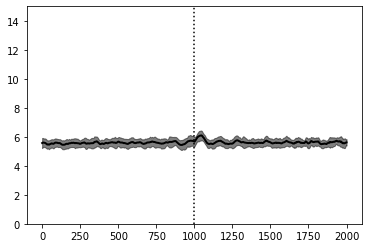

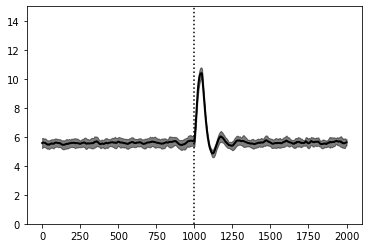

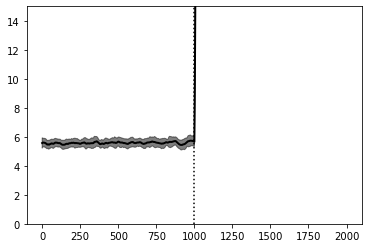

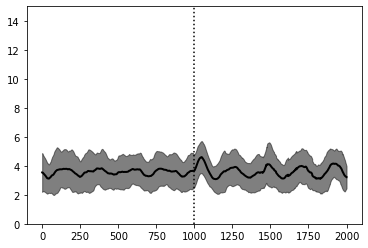

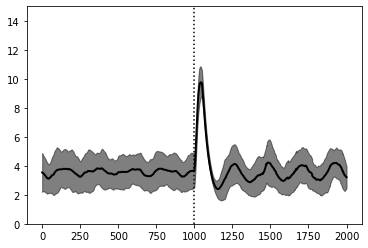

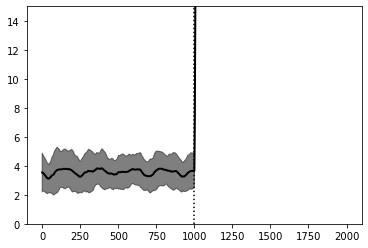

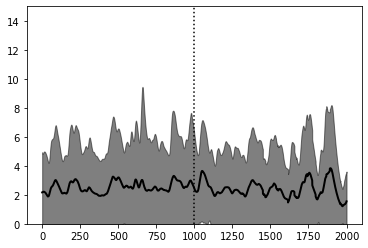

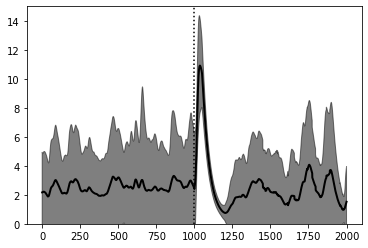

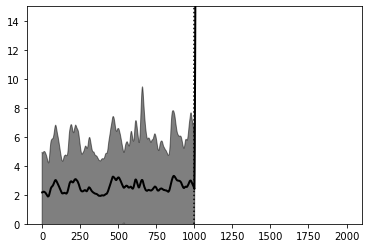

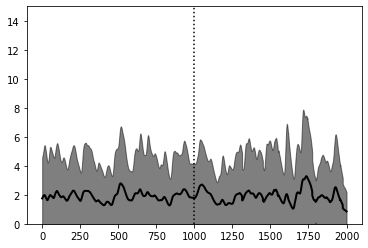

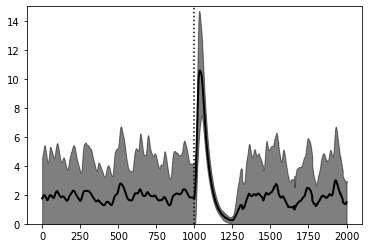

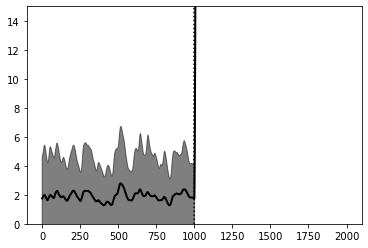

In [18]:
# plot signals and means

# plotting mean over seeds, now aligned to stim onset

#plt.figure()

# # Loop over values of b_e
# bvals = [60] #Values of spike-frequency adaptation giving synchronous and asynchronous states

# # Loop over values of stimulus strength
# stimvals = [1e-5]#[1e-7,1e-6,1e-5] 

#PaintMe = ['DarkSlateGray', 'LightCoral', 'PeachPuff']


id_region_stim = 5

nseeds = Nseeds

timestep_ms = 0.1 # Model dT [ms]

t_plot = 2000 #ms, size of plotting window

means = np.ones((len(bvals), len(stimvals), nseeds, int(t_plot/timestep_ms), nregions))*np.NAN
i=0
for simnum in range(len(bvals)):
    for stim_idx in range(len(stimvals)):
        for seedy in range(nseeds):
            times_l = []
            rateE_m = []
            bE = bvals[simnum]
            ampstim = stimvals[stim_idx]

            folder_path =  folder_root + 'stim_'+str(ampstim)+'_b_'+str(bE)+'_seed_'+str(seedy)+'/'

            nstep = int(run_sim/1000) # number of saved files

            for i_step in range(nstep):
                raw_curr = np.load(folder_path + 'step_'+str(i_step)+'.npy',
                   encoding = 'latin1', allow_pickle=True)
                for i_time in range(len(raw_curr[0])): 
                    times_l.append(raw_curr[0][i_time][0])
                    rateE_m.append(np.concatenate(raw_curr[0][i_time][1][0]))

            times_l = np.array(times_l) # in ms
            rateE_m = np.array(rateE_m) # matrix of size nbins*nregions
            
            trial_whole = rateE_m#[:,id_region_stim]
            trial_aligned = trial_whole[np.logical_and(times_l > stimtime_allseeds[seedy] - t_plot/2,
                                                       times_l < stimtime_allseeds[seedy] + t_plot/2), :]
            idx_start = int(np.max([0,t_plot/2 - stimtime_allseeds[seedy]])/timestep_ms)
            idx_stop = int((t_plot - np.max([0, stimtime_allseeds[seedy] + t_plot/2 - times_l[-1]]))/timestep_ms)+1
            print(times_l, len(trial_aligned), idx_start, idx_stop, idx_stop - idx_start)
            means[simnum, stim_idx, seedy, idx_start:idx_stop, :] = trial_aligned
            
            #plt.plot(np.arange(len(trial_aligned))*timestep_ms, trial_aligned*1e3, color = 'grey', alpha = 0.3)
            #plt.ylim(0,25)
#plt.axvline(t_plot/2, color='gold', linestyle=':')

#mean = np.nanmean(means[simnum, stim_idx,:,:,id_region_stim], axis = 0)*1e3
#plt.plot(np.arange(len(np.nanmean(means[simnum, stim_idx, :, :, id_region_stim], axis = 0)))*timestep_ms, np.nanmean(means[simnum, stim_idx, :, :, id_region_stim], axis = 0)*1e3,label="stim : "+str(stimvals[stim_idx]), color= 'k', linewidth=1.5)
            #axes.axvline((parameters.parameter_stimulus['onset'] - cut_transient)/0.1, color='k', linestyle=':')
            #h_std = mean+np.std(means[simnum, stim_idx])
            #l_std = mean-np.std(means[simnum, stim_idx])
            #axes.fill_between(l_std, h_std, color='grey')
#             axes.set_ylim(ymax=25,ymin=0.)
#             axes.set_xlabel('time [ms/0.1]')
#             axes.set_ylabel('firing rate [Hz]')
#             axes.legend()
        plt.figure()
        ax1=plt.axes()
        ax1.set_ylim(bottom=0, top = 15)
        ax1.axvline(t_plot/2, color='k', linestyle=':')
        
        mean_stimreg = np.nanmean(means[simnum, stim_idx,:,:,id_region_stim], 
                                  axis = 0)*1e3
        std_stimreg = np.nanstd(means[simnum, stim_idx,:,:,id_region_stim], 
                                  axis = 0)*1e3
        ax1.plot(np.arange(len(mean_stimreg))*timestep_ms, 
                 mean_stimreg,
                 label="stim : "+str(stimvals[stim_idx]), 
                 color='black', linewidth=2)
        ax1.fill_between(np.arange(len(mean_stimreg))*timestep_ms, 
                 mean_stimreg - std_stimreg, mean_stimreg + std_stimreg, 
                 label="stim : "+str(stimvals[stim_idx]), 
                 color='black', alpha = 0.5)
        plt.savefig('sig_alignedtostim_mean'+str(nseeds)+'seeds_b'+str(bE)\
                    +'_stim'+str(stimvals[stim_idx])+'.pdf')            
#plt.savefig('Plot_ColorStim_SigNAL_and_Mean' + str(nseeds)+ 'Seeds_b' + str(bvals)+ '_stim' +str(stimvals)+ '.pdf')
# result [0][1][:,0,5]

##### Now calculate the perturbational complexity.
##### First, re-load the data and concatenate the data from the time steps.
##### Select the model state variable for the calculation (here, excitatory firing rate). 
##### Discard the model transient.
##### Define the time for analysis and plot the region of data used. 
##### Now binarise brain regions based on significance of changes in activity induced by the stimulus.
##### Calculate the Lempel-Ziv complexity of the binarized matrix.
##### Normalize the Lempel-Ziv by the entropy of the binarized matrix.

##### This part is a little computationally expensive. If it crashes, try closing your other kernals and try again. 

In [19]:
# Perturbational Complexity Index (PCI) computation and saving
# # # Loop over values of b_e
bE_all = bvals 
ampstim_all = stimvals
timestep_ms = 0.1 # Model dT [ms]

# stimtime_allseeds = np.load(folder_root + 'stimtime_allseeds.npy', encoding = 'latin1')

for ampstim in ampstim_all:
    for bE in bE_all:#bE_all:
        print('\n','bE=', bE, 'amptstim=', ampstim) #100.0# adaptation strength in nS

#%% file reading        
        n_seeds = Nseeds # number of independent random seeds and simulations
        n_trials = 5 # number of simulations/realisations to analyse for one PCI value
        
        
        sim_names = np.arange(0,n_seeds,n_trials) 
        for sim_curr in sim_names:   
            entropy_trials = []
            LZ_trials = []
            PCI_trials = []
            
            sig_all_trials = []
            for i_trials in range(sim_curr, sim_curr + n_trials):
                times_l = []
                rateE_m = []

                folder_path =  folder_root + 'stim_'+str(ampstim)+'_b_'+str(bE)+'_seed_'+str(i_trials)+'/'
                
                nstep = int(run_sim/1000) # number of saved files
                
                for i_step in range(nstep):
                    raw_curr = np.load(folder_path + 'step_'+str(i_step)+'.npy',
                       encoding = 'latin1', allow_pickle=True)
                    for i_time in range(len(raw_curr[0])): 
                        times_l.append(raw_curr[0][i_time][0])
                        rateE_m.append(np.concatenate(raw_curr[0][i_time][1][0]))
                        
                times_l = np.array(times_l) # in ms
                rateE_m = np.array(rateE_m) # matrix of size nbins*nregions
                
                t_total = times_l[-1] # last recorded time
                nbins, nregions = rateE_m.shape
                
                #%% choosing variable of interest
                var_of_interest = rateE_m
                varname = 'rateE'              
                
                #%% discard transient
                nbins_transient = int(cut_transient/times_l[0]) # to discard in analysis   
                sig_region_all = var_of_interest[nbins_transient:,:] 
                sig_region_all = np.transpose(sig_region_all) # now formatted as regions*times
                times = times_l[nbins_transient:]
                sig_all_trials.append(sig_region_all)   
                
            #%% Calculate signal analysis time in bins; model dT * time (bin length = 0.1ms)
            sig_all_trials = np.array(sig_all_trials)
            t_stim_bins = int((stimtime_allseeds[i_trials] - cut_transient)/times_l[0]) #stimulus bin - transient duration in bins
            
            #%% Plot example signals from the stimulated region before and after stimulus (demonstrating what will be used in the analysis)
            #plt.plot(sig_all_trials[0,5,:], '0.5')
            #plt.axvline(t_stim_bins, color = 'r')
            
            #%% analyse only 300 ms before and after stimulus
            t_analysis = 300 #ms
            nbins_analysis =  int(t_analysis/times_l[0])
            
            sig_cut_analysis = sig_all_trials[:,:,
                            t_stim_bins - nbins_analysis:t_stim_bins + nbins_analysis]
                        #%% binarisation
            sig_all_binary = tools.binarise_signals(sig_cut_analysis, int(t_analysis/times_l[0]), 
                                              nshuffles = 10, 
                                 percentile = 100)
            
            #%% return entropy
            for ijk in range(n_trials):
                
                binJ=sig_all_binary.astype(int)[ijk,:,t_analysis:] # CHECK each row is a time series !
                binJs=pci_v2.sort_binJ(binJ) # sort binJ as done in Casali et al. 2013
                source_entropy=pci_v2.source_entropy(binJs)
                print('Entropy', source_entropy)

                #%% return Lempel-Ziv
                Lempel_Ziv_lst=pci_v2.lz_complexity_2D(binJs)
                print('Lempel-Ziv', Lempel_Ziv_lst)

                #normalization factor 
                norm=pci_v2.pci_norm_factor(binJs)


                #%% computing perturbational complexity index
                pci_lst = Lempel_Ziv_lst/norm
                print('PCI', pci_lst)

                all_entropy_lst=[source_entropy,pci_lst]

                entropy_trials.append(all_entropy_lst) 
                LZ_trials.append(Lempel_Ziv_lst) 
                PCI_trials.append(pci_lst) 
    
            #%% file saving
            amp_title= np.array(ampstim)
            save_file_name = folder_path + 'LionelJune2020_Params_PCI_bE' + str(bE) + '_stim'+ str(ampstim) +'trial'+ str(int(sim_curr/n_trials))+ '.npy'
            savefile = {}
            savefile['entropy'] = np.array(entropy_trials)
            savefile['Lempel-Ziv'] = np.array(LZ_trials)
            savefile['PCI'] = np.array(PCI_trials)

            np.save(save_file_name, savefile)
            print(save_file_name)
            print('Seed', sim_curr + ijk, ' done\n')


 bE= 0 amptstim= 1e-05
Entropy 0.2942901257343533
Lempel-Ziv 2167
PCI 0.3526759968955578
Entropy 0.29970582669187396
Lempel-Ziv 2005
PCI 0.3204142868679043
Entropy 0.30763872760425137
Lempel-Ziv 1933
PCI 0.3009425034554645
Entropy 0.29295833595695897
Lempel-Ziv 2070
PCI 0.33842089304990186
Entropy 0.2816213297718221
Lempel-Ziv 1647
PCI 0.28010491933660747
./result/stim_1e-05_b_0_seed_4/LionelJune2020_Params_PCI_bE0_stim1e-05trial0.npy
Seed 4  done

Entropy 0.2963092252295984
Lempel-Ziv 1862
PCI 0.30097275630751374
Entropy 0.2589248655185172
Lempel-Ziv 1908
PCI 0.3529370837277976
Entropy 0.272839101963248
Lempel-Ziv 1686
PCI 0.2959672387460159
Entropy 0.2525486048001169
Lempel-Ziv 2069
PCI 0.3923812071075317
Entropy 0.3003485907954139
Lempel-Ziv 2142
PCI 0.34157537178326297
./result/stim_1e-05_b_0_seed_9/LionelJune2020_Params_PCI_bE0_stim1e-05trial1.npy
Seed 9  done

Entropy 0.25156038675667014
Lempel-Ziv 1708
PCI 0.32519083294688284
Entropy 0.2751224078834764
Lempel-Ziv 1543
PCI 0.268

Entropy 0.3429091815478094
Lempel-Ziv 2393
PCI 0.33423834079902676
Entropy 0.2495670963218923
Lempel-Ziv 2343
PCI 0.44965315432381026
Entropy 0.26561725149117954
Lempel-Ziv 2583
PCI 0.4657585215715272
Entropy 0.2665589132391885
Lempel-Ziv 2240
PCI 0.4024829533062456
Entropy 0.24094204186088855
Lempel-Ziv 2185
PCI 0.43434170986831294
./result/stim_1e-05_b_40_seed_19/LionelJune2020_Params_PCI_bE40_stim1e-05trial3.npy
Seed 19  done

Entropy 0.49922297176094166
Lempel-Ziv 2187
PCI 0.2098200101327247
Entropy 0.42806962922930625
Lempel-Ziv 2208
PCI 0.24704572006995287
Entropy 0.24358007965722264
Lempel-Ziv 1126
PCI 0.2214059583535943
Entropy 0.38133086817400136
Lempel-Ziv 1883
PCI 0.23650538826876677
Entropy 0.30813572314993815
Lempel-Ziv 1815
PCI 0.28211570332661606
./result/stim_1e-05_b_40_seed_24/LionelJune2020_Params_PCI_bE40_stim1e-05trial4.npy
Seed 24  done

Entropy 0.33739085539449554
Lempel-Ziv 2271
PCI 0.32238624862798293
Entropy 0.21933431428401914
Lempel-Ziv 2338
PCI 0.51054097969

Entropy 0.2998558663373949
Lempel-Ziv 1844
PCI 0.2945378069281517
Entropy 0.2891960086315105
Lempel-Ziv 1803
PCI 0.29860433880482856
Entropy 0.27987312100077116
Lempel-Ziv 1968
PCI 0.3367879815472552
Entropy 0.296373896782156
Lempel-Ziv 2007
PCI 0.3243396949787273
Entropy 0.3200057018904041
Lempel-Ziv 2096
PCI 0.3137084691568473
./result/stim_0.0001_b_0_seed_34/LionelJune2020_Params_PCI_bE0_stim0.0001trial6.npy
Seed 34  done

Entropy 0.3136807672806108
Lempel-Ziv 2451
PCI 0.37423818782740625
Entropy 0.2953383146624257
Lempel-Ziv 1906
PCI 0.3090977088181474
Entropy 0.285673185008369
Lempel-Ziv 1954
PCI 0.32760292024607557
Entropy 0.3071519118416836
Lempel-Ziv 1970
PCI 0.3071890176355544
Entropy 0.274675401777813
Lempel-Ziv 2245
PCI 0.39146168282830607
./result/stim_0.0001_b_0_seed_39/LionelJune2020_Params_PCI_bE0_stim0.0001trial7.npy
Seed 39  done


 bE= 20 amptstim= 0.0001
Entropy 0.205792166116037
Lempel-Ziv 1260
PCI 0.29324754736140735
Entropy 0.499067137415931
Lempel-Ziv 2800
PCI 0.

Entropy 0.6006810981695577
Lempel-Ziv 2569
PCI 0.20483908161406963
Entropy 0.24011138362810802
Lempel-Ziv 1134
PCI 0.22620020076128214
Entropy 0.28382686263267415
Lempel-Ziv 1096
PCI 0.1849480426208178
Entropy 0.11820280026584679
Lempel-Ziv 583
PCI 0.23622914133051806
Entropy 0.14435676933485808
Lempel-Ziv 943
PCI 0.3128723761313388
./result/stim_0.0001_b_60_seed_9/LionelJune2020_Params_PCI_bE60_stim0.0001trial1.npy
Seed 9  done

Entropy 0.24243412038466472
Lempel-Ziv 2120
PCI 0.4188271243692028
Entropy 0.7522025628156788
Lempel-Ziv 2815
PCI 0.1792405518085404
Entropy 0.32637887544663335
Lempel-Ziv 2040
PCI 0.2993648509329211
Entropy 0.286681837509961
Lempel-Ziv 2344
PCI 0.39160669656600283
Entropy 0.25963662318470704
Lempel-Ziv 1873
PCI 0.3455130912359602
./result/stim_0.0001_b_60_seed_14/LionelJune2020_Params_PCI_bE60_stim0.0001trial2.npy
Seed 14  done

Entropy 0.5852177001297687
Lempel-Ziv 1408
PCI 0.11523326932622474
Entropy 0.5662865174772304
Lempel-Ziv 1824
PCI 0.1542699341161382

Entropy 0.36030473305406097
Lempel-Ziv 1057
PCI 0.1405069161517899
Entropy 0.36349270343469436
Lempel-Ziv 2027
PCI 0.2670857595987785
Entropy 0.23482553326511063
Lempel-Ziv 1325
PCI 0.2702484693579218
Entropy 0.3052325925542651
Lempel-Ziv 1162
PCI 0.18233410281942788
Entropy 0.44076959382774933
Lempel-Ziv 2508
PCI 0.2725264045602217
./result/stim_0.001_b_20_seed_24/LionelJune2020_Params_PCI_bE20_stim0.001trial4.npy
Seed 24  done

Entropy 0.42876738077876286
Lempel-Ziv 1723
PCI 0.1924669752129258
Entropy 0.4097338044086349
Lempel-Ziv 2522
PCI 0.2948057622097473
Entropy 0.47821793022649606
Lempel-Ziv 2292
PCI 0.22955218960461604
Entropy 0.3811711269712057
Lempel-Ziv 2190
PCI 0.2751799582915851
Entropy 0.433154275755185
Lempel-Ziv 2095
PCI 0.23165095948871198
./result/stim_0.001_b_20_seed_29/LionelJune2020_Params_PCI_bE20_stim0.001trial5.npy
Seed 29  done

Entropy 0.490688049222462
Lempel-Ziv 2071
PCI 0.2021469997370398
Entropy 0.23800546301428233
Lempel-Ziv 1945
PCI 0.3914040920715317
En

Entropy 0.48494278187532625
Lempel-Ziv 1707
PCI 0.16859151117478868
Entropy 0.0588558067333947
Lempel-Ziv 61
PCI 0.04964016311715051
Entropy 0.30390353492572386
Lempel-Ziv 1217
PCI 0.19179951664092015
Entropy 0.19270705831552062
Lempel-Ziv 61
PCI 0.015160896918750237
Entropy 0.5226568630511871
Lempel-Ziv 2156
PCI 0.1975717200557468
./result/stim_0.001_b_60_seed_39/LionelJune2020_Params_PCI_bE60_stim0.001trial7.npy
Seed 39  done



/Users/kevinancourt/opt/anaconda3/envs/tvb-run/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


3000
[282.2   nan 146.8   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   0.    nan   nan   nan   nan 274.8
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan 265.4 216.8   nan   nan   nan   nan 277.5   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan]


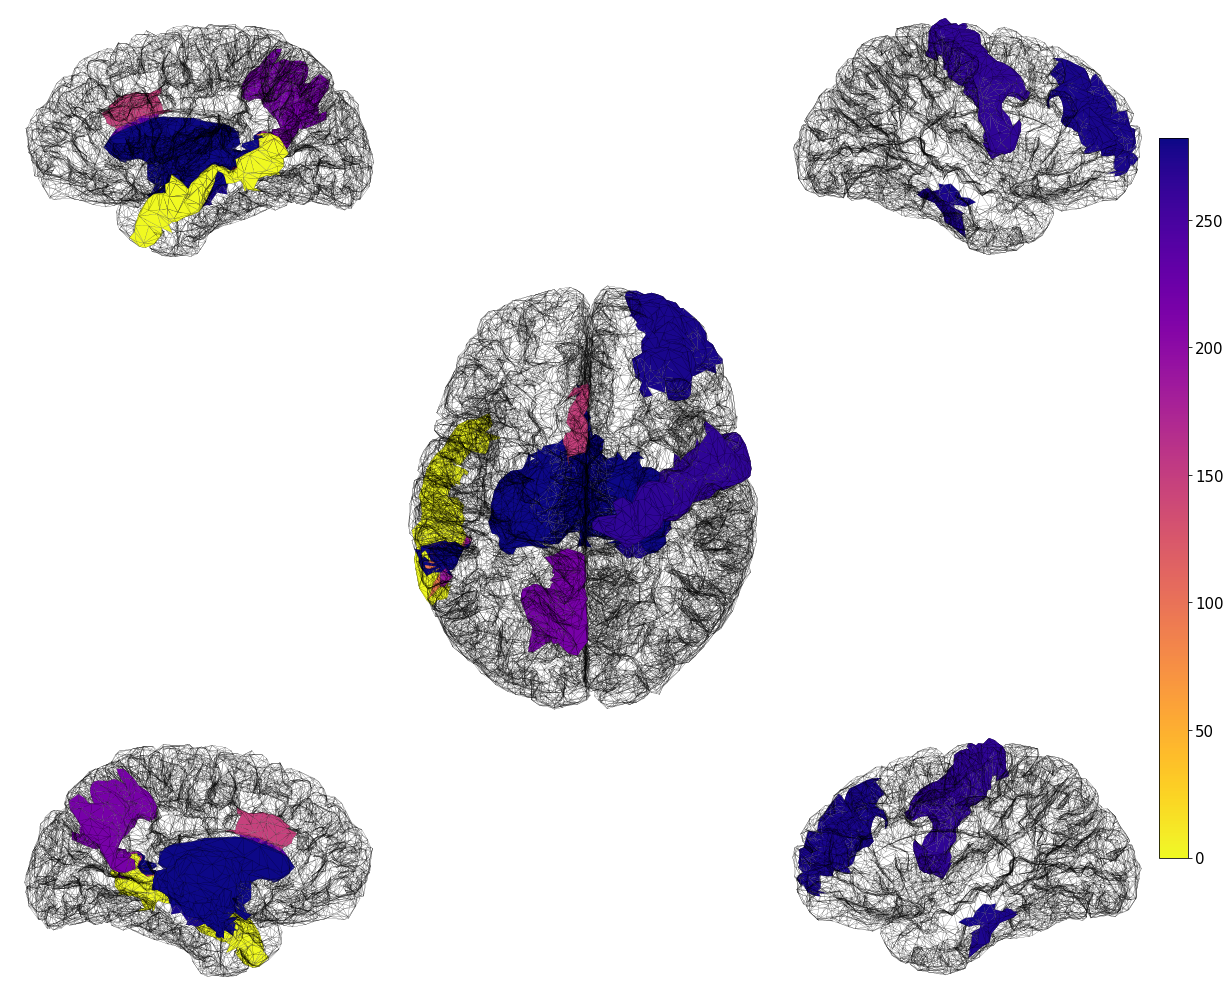

In [20]:
# #extract and plot first time significant by region

i_adap=0
i_stimval=0

# Import resources
from tvb_model_reference.view.plot import multiview,multiview_one
from tvb.simulator.lab import cortex as ct
from tvb.simulator.lab import region_mapping as rm
from tvb.simulator.lab import surfaces as surf

# Import data of surface
region_mapping_data = np.loadtxt(parameters.parameter_connection_between_region['path']+'/RegionMapping.txt',dtype=np.int)
surface_cortex = surf.Surface().from_file(parameters.parameter_connection_between_region['path']+'/Surface_Cortex.zip')
hemispheres_right = np.where([False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True])[0]
hemispheres_left = np.where(np.logical_not([False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True]))[0]

# Configure surface data for ploting
tmp = np.copy(surface_cortex.vertices[:,0])
surface_cortex.vertices[:,0] = surface_cortex.vertices[:,1]
surface_cortex.vertices[:,1] = tmp
region_mapping=rm.RegionMapping(array_data=region_mapping_data,connectivity=simulator.connectivity,surface=surface_cortex)
cortex = ct.Cortex().from_file()
cortex.region_mapping_data = region_mapping

## plot
Nregions = len(sig_all_binary[-1])
first_time_sig = np.ones(Nregions)*np.NAN
print(int(len(sig_all_binary[-1,0])/2))
for i_reg in range(Nregions):
    times_sig_curr = np.where(sig_all_binary[-4,i_reg,int(len(sig_all_binary[-1,0])/2):] == 1)[0]*timestep_ms
    if len(times_sig_curr) > 0: #significant once or more
        first_time_sig[i_reg] = times_sig_curr[0]

print(first_time_sig)

#%% And plot
the_data = first_time_sig
cmap = plt.cm.plasma #coolwarm #RdYlBu #YlGnBu #plt.cm.RdGy
cmap = cmap.reversed()
cmap.set_under(color='whitesmoke')
multiview(cortex,hemispheres_left,hemispheres_right,the_data[region_mapping.array_data],plt.figure(figsize=(20, 20)), shaded=False,CB_position=[0.8, 0.25, 0.02, 0.5],
          CB_orientation='vertical',CB_fontsize=15,zmin=0,zmax=np.nanmax(the_data),cmap=cmap)

plt.savefig('Plot_FirstTimeSignif_b'+str(bvals[i_adap])+'_stim'+str(stimvals[i_stimval])+'_seeds'+str(Nseeds)+'.png')

In [21]:
print(np.sum(sig_all_binary[-1,:,int(len(sig_all_binary[-1,0])/2):], axis = 1))

[ 309 1131    0  647  442 2958  736  565  549 2824  649  801  780  461
  742  557   94  306  139  562  733  828  583  866 1103  235  460  876
  652  762    0  274  560  556    0  674  351  979  858   58    0  289
 1078  275    0  527    0    0  568  898  709  267  131  827  958 1116
  924 1075  100    0    2  364    0  198    0 1373    0   33]


0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5
0 5
1 5
2 5
3 5
4 5
5 5
6 5
7 5


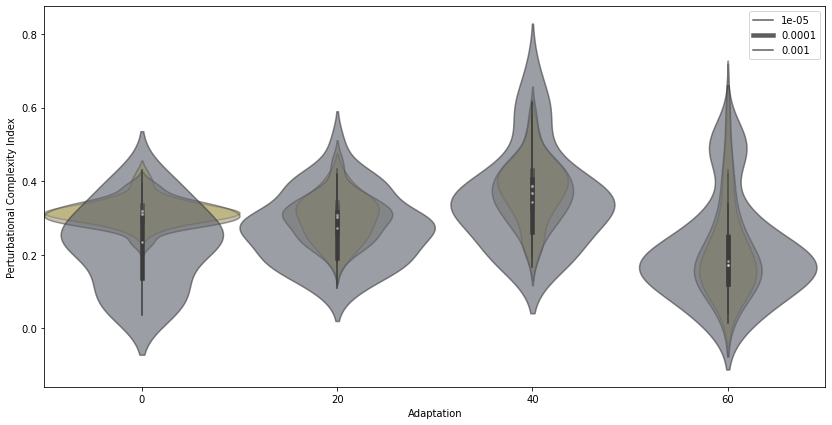

In [22]:
# # # Loop over values of b_e
# bvals = [0] #Values of spike-frequency adaptation giving synchronous and asynchronous states

# # # Loop over values of stimulus strength
# stimvals = [1e-4] #[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2] 

n_trials = 5

cmap = plt.get_cmap('cividis_r')

bE_all = bvals #np.linspace(0,20,11)
ampstim_all = stimvals
PCI_all=[]

ctr = 0
plt.figure(figsize=[14,7])
for ampstim in ampstim_all:
    PCI_states = []

    for bE in bE_all:
        PCI_curr = []
        for i_trials in range(int(Nseeds/n_trials)):
            folder_path = folder_root + 'stim_'+str(ampstim)+'_b_'+str(bE)+'_seed_'+str(i_trials*n_trials+4)+'/'
            file_name = folder_path + 'LionelJune2020_Params_PCI_bE' + str(bE) + '_stim'+ str(ampstim) +'trial'+ str(i_trials)+ '.npy'

            data_curr = np.load(file_name, encoding = 'latin1', allow_pickle = True).item()
            PCI_curr.append(data_curr['PCI'][-n_trials:])
            print(i_trials, len(data_curr['PCI']))
        PCI_states.append(np.concatenate(PCI_curr))
    
    ax = seaborn.violinplot(data = PCI_states, width = 1., saturation = 0.75, 
                       color = cmap(int(ctr/len(ampstim_all)*255)), 
                       label = 'amp = '+ str(ampstim), alpha = 0.1)
    ctr += 1
    PCI_all.append(PCI_states)

plt.setp(ax.collections, alpha=.6)


plt.xticks(np.arange(len(bE_all)), 
           bE_all)
plt.xlabel('Adaptation')
plt.ylabel('Perturbational Complexity Index')
plt.legend(ampstim_all)
plt.savefig('Plot_violins_PCI.png')
plt.show()

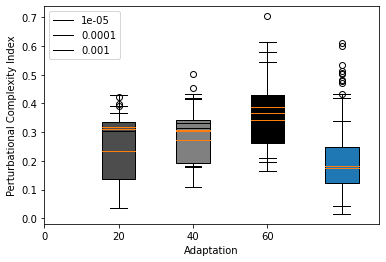

In [23]:
# Boxplots of PCI data
ampstim_colors=['0.3','0.5','0.']
plt.figure()
#print(PCI_all[0]) #len = (3,4) chaque [0,*] = une bval
#print(PCI_states)


for PCI_states in PCI_all:
        bplot=plt.boxplot(PCI_states,patch_artist=True)
        for patch,color in zip(bplot['boxes'], ampstim_colors):
            patch.set_facecolor(color)

plt.xticks(np.arange(len(bE_all)), bE_all)
plt.xlabel('Adaptation')
plt.ylabel('Perturbational Complexity Index')
plt.legend(ampstim_all)
plt.savefig('Boxplot_PCI.pdf')
plt.show()


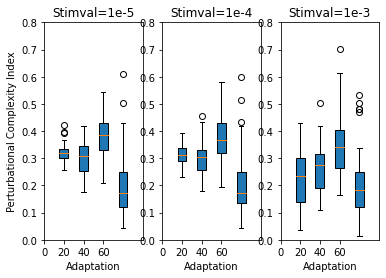

In [24]:
fig = plt.figure()
ax1=fig.add_subplot(1,3,1)
ax1.set_xlim(left=0, right = 5)
ax1.set_ylim(bottom=0, top = 0.8)
plt.ylabel('Perturbational Complexity Index')
plt.xlabel('Adaptation')
ax1.boxplot(PCI_all[0],patch_artist=True)
plt.title(label="Stimval=1e-5")
ax2=fig.add_subplot(1,3,2,sharey=ax1,sharex=ax1)
plt.xlabel('Adaptation')
ax2.boxplot(PCI_all[1],patch_artist=True)
plt.title(label="Stimval=1e-4")
ax3=fig.add_subplot(1,3,3,sharey=ax1,sharex=ax1)
plt.xlabel('Adaptation')
ax3.boxplot(PCI_all[2],patch_artist=True)
plt.title(label="Stimval=1e-3")
plt.xticks(np.arange(len(bE_all)), bE_all)
plt.xlabel('Adaptation')


fig.savefig('Boxplot_PCI.pdf')
plt.show()



In [25]:
# Statistics of PCI data
# Comparison between bvals
from scipy import stats
print(stats.mannwhitneyu(PCI_states[0], PCI_states[1]))
print(len(PCI_all)) 

MannwhitneyuResult(statistic=643.0, pvalue=0.06604360524495309)
3


In [26]:
from scipy.stats import f_oneway

#ANOVA 
for i in range (len(PCI_all)):
    F, p = f_oneway(PCI_all[i][0],PCI_all[i][1],PCI_all[i][2],PCI_all[i][3])
    print("The F statistic for a stimulus strength = ",stimvals[i] ,"Hz equals ",F)
    print("The p value for a stimulus at", stimvals[i], "Hz is equals ", p ,"\n" )



The F statistic for a stimulus strength =  1e-05 Hz equals  28.647092256572563
The p value for a stimulus at 1e-05 Hz is equals  8.223852288693152e-15 

The F statistic for a stimulus strength =  0.0001 Hz equals  26.57749426085294
The p value for a stimulus at 0.0001 Hz is equals  6.102034419616111e-14 

The F statistic for a stimulus strength =  0.001 Hz equals  12.3524274885777
The p value for a stimulus at 0.001 Hz is equals  2.713405901017256e-07 



In [27]:
import scipy.stats as stat

for i in range (len(PCI_all)):
    for j in range (len(PCI_all[0])):
        Agostino=stat.normaltest(PCI_all[i][j])
        print("For a stimval equal to ", stimvals[i],"and a bvals equal to", bvals[j], " we obtain with a Normality test ", Agostino, "\n")



For a stimval equal to  1e-05 and a bvals equal to 0  we obtain with a Normality test  NormaltestResult(statistic=10.109623559741685, pvalue=0.006378567224099821) 

For a stimval equal to  1e-05 and a bvals equal to 20  we obtain with a Normality test  NormaltestResult(statistic=0.7976790902302596, pvalue=0.6710983737272287) 

For a stimval equal to  1e-05 and a bvals equal to 40  we obtain with a Normality test  NormaltestResult(statistic=0.5550578997628959, pvalue=0.7576536303027024) 

For a stimval equal to  1e-05 and a bvals equal to 60  we obtain with a Normality test  NormaltestResult(statistic=15.938142242936404, pvalue=0.00034600022885774385) 

For a stimval equal to  0.0001 and a bvals equal to 0  we obtain with a Normality test  NormaltestResult(statistic=0.623956452823512, pvalue=0.7319974662662241) 

For a stimval equal to  0.0001 and a bvals equal to 20  we obtain with a Normality test  NormaltestResult(statistic=1.2702418228327705, pvalue=0.5298714169406418) 

For a stimv

In [28]:
import scikit_posthocs as sp

for i in range(len(PCI_all)):
    print("For a stimval equals ", stimvals[i])
    Post_hoc=sp.posthoc_ttest(PCI_all[i], p_adjust = 'holm')
    print(Post_hoc, "\n") # number's column are for bvals, #1=0 #2=20 #3=40 #4=60

For a stimval equals  1e-05
          1         2             3             4
1  1.000000  0.062385  3.128213e-04  2.581015e-06
2  0.062385  1.000000  3.763020e-05  2.538662e-04
3  0.000313  0.000038  1.000000e+00  3.035172e-09
4  0.000003  0.000254  3.035172e-09  1.000000e+00 

For a stimval equals  0.0001
          1         2             3             4
1  1.000000  0.213329  2.683858e-04  1.298403e-05
2  0.213329  1.000000  9.659367e-05  2.683858e-04
3  0.000268  0.000097  1.000000e+00  8.087088e-09
4  0.000013  0.000268  8.087088e-09  1.000000e+00 

For a stimval equals  0.001
          1         2         3         4
1  1.000000  0.134597  0.000080  0.376710
2  0.134597  1.000000  0.006648  0.032013
3  0.000080  0.006648  1.000000  0.000015
4  0.376710  0.032013  0.000015  1.000000 



In [29]:
# ANOVA Non-parametric

for i in range (len(PCI_all)):
    H, p = stat.kruskal(PCI_all[i][0],PCI_all[i][1],PCI_all[i][2],PCI_all[i][3])
    print("The H statistic for a stimulus strength = ",stimvals[i] ,"Hz equals ",H)
    print("The p value for a stimulus at", stimvals[i], "Hz is equals ", p ,"\n" )


The H statistic for a stimulus strength =  1e-05 Hz equals  54.77811335403726
The p value for a stimulus at 1e-05 Hz is equals  7.656832729846287e-12 

The H statistic for a stimulus strength =  0.0001 Hz equals  52.68184006211186
The p value for a stimulus at 0.0001 Hz is equals  2.143261628116749e-11 

The H statistic for a stimulus strength =  0.001 Hz equals  31.45558229813662
The p value for a stimulus at 0.001 Hz is equals  6.815494450769299e-07 



In [30]:
for i in range(len(PCI_all)):
    print("For a stimval equals ", stimvals[i])
    Post_hoc=sp.posthoc_conover(PCI_all[i], p_adjust = 'holm')
    print(Post_hoc, "\n") # number's column are for bvals, #1=0 #2=20 #3=40 #4=60

For a stimval equals  1e-05
              1         2             3             4
1  1.000000e+00  0.216855  1.793333e-03  5.741690e-07
2  2.168551e-01  1.000000  3.110663e-05  8.327177e-05
3  1.793333e-03  0.000031  1.000000e+00  6.113286e-15
4  5.741690e-07  0.000083  6.113286e-15  1.000000e+00 

For a stimval equals  0.0001
          1         2             3             4
1  1.000000  0.342113  1.893258e-03  1.612964e-06
2  0.342113  1.000000  8.410588e-05  8.410588e-05
3  0.001893  0.000084  1.000000e+00  2.477058e-14
4  0.000002  0.000084  2.477058e-14  1.000000e+00 

For a stimval equals  0.001
          1         2             3             4
1  1.000000  0.229881  1.185377e-04  2.298808e-01
2  0.229881  1.000000  1.689163e-02  8.195868e-03
3  0.000119  0.016892  1.000000e+00  1.057536e-07
4  0.229881  0.008196  1.057536e-07  1.000000e+00 

